# Tiling - Predicting - Mosaicing

##### Before the data can be used in the model, they have to tiled to 256x256


https://towardsdatascience.com/efficiently-splitting-an-image-into-tiles-in-python-using-numpy-d1bf0dd7b6f7

TODO
1) Tif lesen, georeferenzierten Punkt oben links für späteres Nutzen erstellen 
2) JPEG erstellen
3) tiling
4) Klassifizierung 
5) wieder zusammensetzten der Tiles 
6) Georeferenzierung wieder hinzufügen (maybe 5?))

In [1]:
import os
import sys
from PIL import Image
from osgeo import gdal
import numpy as np
import rasterio
from osgeo import osr
import geopandas as gpd
from shapely.geometry import Point
from pyproj import CRS
import glob
import re
import pandas as pd
import matplotlib.pyplot as plt
import warnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

import imageio

### Set working directory

In [2]:
os.getcwd()
os.chdir('E:/W_Katrin/Kigali/Raster/')
os.getcwd()

'E:\\W_Katrin\\Kigali\\Raster'

### Define global variables

In [3]:
ORIGINAL_IMG = "2015_Pleiades_Kigali_subset_.tif"
TILE_DIRECTORY = "E:/W_Katrin/Kigali/Raster/2022-03-29-tiles_m5_subset_"
IMG_RESOLUTION = {}
POINT_FILE = {}

## 1) Create Point for Georeferencing [upper left corner]
hier einfügen: if point already exists, you do not have to create it!

In [4]:
# get coordinates from raster
src = gdal.Open(ORIGINAL_IMG)
ulx, xres, xskew, uly, yskew, yres  = src.GetGeoTransform() # ulx, uly = upper left x and y values
# define global variable IMG_RESOLUTION
IMG_RESOLUTION = xres
# get projection from raster
wkt = src.GetProjection()
src_crs = osr.SpatialReference(wkt).GetAttrValue('AUTHORITY',1)

print("ulx, uly:", ulx, ",", uly, ",","xres, yres:", xres,",", yres)
print("SRC_CRS:", src_crs)

ulx, uly: 0.0 , 0.0 , xres, yres: 1.0 , 1.0
SRC_CRS: None


In [6]:
# create Point 
point = Point(ulx, uly)
print("Point:", point)

#create new GeoDataFrame to save the point in
newdata = gpd.GeoDataFrame()
newdata['geometry'] = None
newdata.loc[0, 'geometry'] = point

# Set the GeoDataFrame's coordinate system to the same as the src raster 
newdata.crs = CRS.from_epsg(src_crs)
print("GeoDataFrame CRS:", newdata.crs)

#save GeoDataFrame
POINT_FILE = "2015_Pleiades_Kigali_subset_ReferencePointUL.shp"
newdata.to_file(POINT_FILE)

SRC_CRS: 32736
Point: POINT (173723.36172185623 9789230.701895246)
GeoDataFrame CRS: epsg:32736


E:\W_Katrin\miniconda3\envs\tue_dl2\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## 2) Convert input - file (Tif) to JPEG OR RESCALE
#### using gdal translate
https://gis.stackexchange.com/questions/42584/how-to-call-gdal-translate-from-python-code

### Rescaling Input Raster to Uint8

##### trying to convert Satellite image to Uint8 by hand, seems like the results are the same

#### Try 1

In [71]:
# for trying to change convert to int by hand
# get min/max from QGIS Symbolization, Min/MAx Einstellungen Kumulativer Zählschnitt 2,0 - 98%
def normalize8(I, mn, mx):
    mx -= mn
    I = ((I - mn)/mx) * 255
    return I.astype(np.uint8)

In [72]:
src = gdal.Open(filename)
src_array = src.ReadAsArray()
src_uint8 = normalize8(src_array, 0, 1800)

In [73]:
print(src_uint8.min())
print(src_uint8.max())
print(src_uint8.mean())
src_uint8.shape

0
255
98.40632405104026


(5, 8267, 13162)

#### Try 2

In [67]:
def convert(img, target_type_min, target_type_max, target_type):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

In [10]:
imgu8 = convert(src_array, 0, 255, np.uint8)

In [11]:
print(imgu8.min())
print(imgu8.max())
print(imgu8.mean())

0
255
28.614318429952384


In [75]:
format = "GTiff"
driver = gdal.GetDriverByName(format)
dst_filename = "E:/W_Katrin/Kigali/Raster/2015_Pleiades_Kigali_subset_Uint8_8.tif"
width = src.RasterXSize
height = src.RasterYSize
dst_ds = driver.Create(dst_filename, width, height, 5)
dst_ds.WriteRaster(0,0,width, height, src_uint8, band_list=[1,2,3,4,5])

0

#### Try 3 - each band separetly after already rescaling in QGIS

In [81]:
b1 = gdal.Open("E:/W_Katrin/Kigali/Raster/2015_Pleiades_Kigali_subset_rescale_B1.tif")
b2 = gdal.Open("E:/W_Katrin/Kigali/Raster/2015_Pleiades_Kigali_subset_rescale_B2_2.tif")
b3 = gdal.Open("E:/W_Katrin/Kigali/Raster/2015_Pleiades_Kigali_subset_rescale_B3.tif")

In [83]:
b1_int = b1.ReadAsArray().astype(np.uint8)
b2_int = b2.ReadAsArray().astype(np.uint8)
b3_int = b3.ReadAsArray().astype(np.uint8)

In [72]:
b1_array = b1.ReadAsArray()
b2_array = b2.ReadAsArray()
b3_array = b3.ReadAsArray()

In [73]:
b1_norm = normalize8(b1_array, -6, 300)
b2_norm = normalize8(b2_array, -40, 500)
b3_norm = normalize8(b3_array, 0, 300)

NameError: name 'normalize8' is not defined

In [76]:
b1_norm = convert(b1_array, 0,255, np.uint8)
b2_norm = convert(b2_array, 0,255, np.uint8)
b3_norm = convert(b3_array, 0,255, np.uint8)

In [78]:
src = gdal.Open(filename)

In [75]:
print("B1", b1_norm.min(),b1_norm.max(),b1_norm.mean(), b1_norm.shape, b1_norm.std())
#print("B2", b2_norm.min(),b2_norm.max(),b2_norm.mean(), b2_norm.std())
#print("B3", b3_norm.min(),b3_norm.max(),b3_norm.mean(), b3_norm.std())

B1 0 255 27.47782574792997 (8267, 13162) 11.339135603982013


In [85]:
format = "GTiff"
driver = gdal.GetDriverByName(format)
dst_filename = "E:/W_Katrin/Kigali/Raster/2015_Pleiades_Kigali_subset_Uint8_14.tif"
width = src.RasterXSize
height = src.RasterYSize
dst_ds = driver.Create(dst_filename, width, height, 3)
dst_ds.GetRasterBand(1).WriteArray(b1_int)
dst_ds.GetRasterBand(2).WriteArray(b2_int)
dst_ds.GetRasterBand(3).WriteArray(b3_int)

#dst_ds.WriteRaster(0,0,width, height, src_uint8, band_list=[1,2,3,4,5])

0

### try 4 each band separetly, by hand, by using breakpoints from ErDAS Imagine

In [91]:
def convert2(img, imin, imax, target_type_min, target_type_max, target_type):
    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

In [92]:
src = gdal.Open("E:/W_Katrin/Kigali/Raster/2015_Pleiades_Kigali_subset.tif")
b1 = src.GetRasterBand(1).ReadAsArray()
b2 = src.GetRasterBand(2).ReadAsArray()
b3 = src.GetRasterBand(3).ReadAsArray()

In [120]:
b1_conv = convert2(b1, 211, 3094, 0, 255, np.uint8)
b2_conv = convert2(b2, 271, 2799, 0, 255, np.uint8)
b3_conv = convert2(b3, 0, 1900, 0, 255, np.uint8)

In [122]:
format = "GTiff"
driver = gdal.GetDriverByName(format)
dst_filename = "E:/W_Katrin/Kigali/Raster/2015_Pleiades_Kigali_subset_Uint8_conv2_10.tif"
width = src.RasterXSize
height = src.RasterYSize
dst_ds = driver.Create(dst_filename, width, height, 3)
dst_ds.GetRasterBand(1).WriteArray(b1_conv)
dst_ds.GetRasterBand(2).WriteArray(b2_conv)
dst_ds.GetRasterBand(3).WriteArray(b3_conv)

0

#### actual translation

In [115]:
!gdal_translate -of PNG -b 1 -b 2 -b 3 -scale -co "WORLDFILE=YES" E:/W_Katrin/Kigali/Raster/2015_Pleiades_Kigali_subset.tif E:/W_Katrin/Kigali/Raster/2015_Pleiades_Kigali_subset_RGB.png

Input file size is 13162, 8267

Warning 6: PNG driver doesn't support data type Float32. Only eight bit (Byte) and sixteen bit (UInt16) bands supported. Defaulting to Byte




0...10...20...30...40...50...60...70...80...90...100 - done.


In [ ]:
dst = gdal.Open("E:/W_Katrin/Kigali/Raster/2015_Pleiades_Kigali_subset_RGB.png")
dst.GetMetadata()
!gdalinfo E:/W_Katrin/Kigali/Raster/2015_Pleiades_Kigali_subset_RGB.png

## 3) TILING of input data
##### - Input raster has to be tiled to feed the model for prediction - 

In [5]:
# define tiling function 
def tiling(filename, savedir, target_size): 
    if not os.path.exists(savedir): os.mkdir(savedir)
    img = Image.open(filename)
    width, height = img.size
    start_pos = start_x, start_y = (0, 0)
    cropped_image_size = w, h = target_size
    frame_num = 1
    for col_i in range(0, width, w):
        for row_i in range(0, height, h):
            crop = img.crop((col_i, row_i, col_i + w, row_i + h))
            length = 5
            padding='0'
            save_to= os.path.join(savedir, "testing_{col}_{row}.png".format(col=format(col_i, padding + '>'+ str(length)), row=format(row_i, padding + '>'+ str(length))))
            crop.save(save_to)


In [6]:
# run tiling
filename = "2015_Pleiades_Kigali_subset_.tif"

warnings.simplefilter('ignore', Image.DecompressionBombWarning)

tiling(filename, TILE_DIRECTORY, target_size = (256,256))

## 4) Predict and save predicted masks 

In [7]:
#Load the model
model_improved = keras.models.load_model("E:/W_Katrin/InnovationLab/models/5_model_improved")

In [8]:
# add here the folder path, where your  data is stored
files = glob.glob(os.path.join(TILE_DIRECTORY,'*'))
pattern_img = '.*\.png'
# create a list of all images in that directory [after converting them to jpg with the code in Github README]
files_img = list(filter(re.compile(pattern_img).match,files))
files_img = sorted(files_img)

print('Image files: {}\n'.format(len(files_img)))

Image files: 1716



In [9]:
# create a dataframe of the satellite images
df_files = pd.DataFrame(columns=['img'])
df_files['img'] = files_img

In [10]:
def make_test_gen(df_test,target_size,batch_size,seed):# this function generates augmented data[!not only training data!]
    # or better said: it generates a function which generates augmented data[generator function]
    
    # https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/
    # generate batches of tensor image data with real-time data augmentation 
    # batches of original training data are randomly transformed and then used for training (not the original data!)
  test_gen = keras.preprocessing.image.ImageDataGenerator()
    
    # read data from dataframe and perform powerful on-the-fly image augmentation with ImageDataGenerator
  test_generator = test_gen.flow_from_dataframe(
          dataframe=df_test,        
          x_col='img',
          target_size=target_size,
          batch_size=batch_size,
          seed = seed,
          class_mode=None,
          color_mode='rgb',
          shuffle=False)
  return test_generator

In [11]:
test_image_gen = make_test_gen(df_files, batch_size = 1,target_size = (256, 256), seed = 0) #seed 0 to keep the Reihenfolge

Found 1716 validated image filenames.


In [12]:
# Generate output predictions for the input samples
mask_predicted = model_improved.predict(test_image_gen, verbose = 1)

1716/1716 [==============================] - 214s 125ms/step


In [13]:
# add predicted masks to dataframe df_files
df_files["mask_file"] = mask_predicted

In [14]:
#save predicted maps
def save_pred(predicted, savedir):
    for i in range(len(predicted)):
        pred = np.squeeze(predicted[i])
        pred = (255*(pred - np.min(pred))/np.ptp(pred)).astype("uint8")
        padding = '0'
        length = 4
        save_to = os.path.join(savedir, "testing_{x}.tif".format(x = format(i, padding + '>' + str(length))))
        imageio.imwrite(save_to, pred)

In [15]:
_ = save_pred(mask_predicted,TILE_DIRECTORY)

In [16]:
# define function to display the results
def predict_buildings(img, mask_pred):
    i=0
    img=img[i].astype(int)
    mask_pred=np.squeeze(mask_pred[i])
    mask_pred_rend=np.argmax(mask_pred, axis=-1)
    plt.figure(figsize=0.8*np.array([3*6.4, 4.8]))
    plt.subplot(131) # = plt.subplot(1,3,1), 1 row, 4 columns,  first subplot (from right to left, first top row)
    plt.imshow(img)
    plt.subplot(132)
    plt.imshow(mask_pred)
    plt.subplot(133)
    plt.imshow(mask_pred_rend)
    plt.show()
    
    return mask_pred, mask_pred_rend

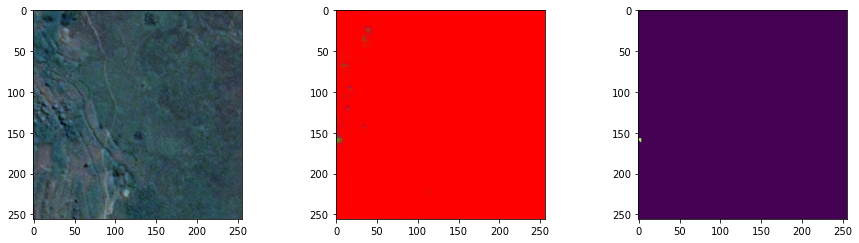

In [17]:
img_test = next(test_image_gen)
mask_predicted_, mask_predicted_rend_= predict_buildings(img_test, mask_predicted)

## 5) Mosaic - Put images back together

### 5.1) Mosaic preparation

In [18]:
# if starting the Code here: RUN THIS CELL
# create a dataframe of the satellite image tiles and their respective masks
files = glob.glob(os.path.join(TILE_DIRECTORY,'*'))
pattern_img = '.*\.png$'
files_img = list(filter(re.compile(pattern_img).match,files))
files_img = sorted(files_img)

pattern_mask = '.*\.tif$'
files_mask = list(filter(re.compile(pattern_mask).match,files))
files_mask = sorted(files_mask)

df_files = pd.DataFrame(columns=['img','mask', 'X', 'Y'])
df_files['img'] = files_img
df_files['mask'] = files_mask


In [19]:
# read the upper left corner coordinates from the img-filename and save it in X and Y
for i in range(df_files.shape[0]): 
    string = df_files["img"].iloc[i]
    string = string.split('\\')[-1].split('.')[0].split('_')
    x = string[-2]
    y = string[-1]
    df_files['X'].iloc[i] = x
    df_files['Y'].iloc[i] = y

df_files

,img,mask,X,Y
0,E:/W_Katrin/Kigali/Raster/2022-03-29-tiles_m5_...,E:/W_Katrin/Kigali/Raster/2022-03-29-tiles_m5_...,00000,00000
1,E:/W_Katrin/Kigali/Raster/2022-03-29-tiles_m5_...,E:/W_Katrin/Kigali/Raster/2022-03-29-tiles_m5_...,00000,00256
2,E:/W_Katrin/Kigali/Raster/2022-03-29-tiles_m5_...,E:/W_Katrin/Kigali/Raster/2022-03-29-tiles_m5_...,00000,00512
3,E:/W_Katrin/Kigali/Raster/2022-03-29-tiles_m5_...,E:/W_Katrin/Kigali/Raster/2022-03-29-tiles_m5_...,00000,00768
4,E:/W_Katrin/Kigali/Raster/2022-03-29-tiles_m5_...,E:/W_Katrin/Kigali/Raster/2022-03-29-tiles_m5_...,00000,01024
...,...,...,...,...
1711,E:/W_Katrin/Kigali/Raster/2022-03-29-tiles_m5_...,E:/W_Katrin/Kigali/Raster/2022-03-29-tiles_m5_...,13056,07168
1712,E:/W_Katrin/Kigali/Raster/2022-03-29-tiles_m5_...,E:/W_Katrin/Kigali/Raster/2022-03-29-tiles_m5_...,13056,07424
1713,E:/W_Katrin/Kigali/Raster/2022-03-29-tiles_m5_...,E:/W_Katrin/Kigali/Raster/2022-03-29-tiles_m5_...,13056,07680
1714,E:/W_Katrin/Kigali/Raster/2022-03-29-tiles_m5_...,E:/W_Katrin/Kigali/Raster/2022-03-29-tiles_m5_...,13056,07936


In [20]:
# create worldfiles for every mask tile to add georeferencing to them 
def create_worldfiles(dataframe, res, point_path):
    point = gpd.read_file(point_path)
    x_coord = point["geometry"].x[0]
    y_coord = point["geometry"].y[0]
    for i in range(len(dataframe)): 
        directory = dataframe["mask"].iloc[i].split('\\')[0]
        mask_str = dataframe["mask"].iloc[i].split('\\')[-1].split('.')[0]
        ext_ = dataframe["mask"].iloc[i].split('\\')[-1].split('.')[-1]
        if ext_ == 'tif': 
            ext = '.tfw'
        elif ext_ == 'png':
            ext = '.pgw'
        elif ext_ == 'jpg':
            ext = '.jgw'
        else:
            print("File Extension not known, accepted as input: TIF, PNG, JPG")
        f = open(os.path.join(directory, mask_str + ext), "w")
        f.write('{pixel_size}\n'.format(pixel_size = res)) #pixel size x
        f.write('0.0\n') #rotation
        f.write('0.0\n') #rotation
        f.write('{pixel_size}\n'.format(pixel_size = -res)) #pixel size y
        f.write('{easting}\n'.format(easting = (x_coord + (res*int(dataframe["X"].iloc[i]))))) #location x
        # be aware! In southern Hemisphere here minus instead of plus!
        f.write('{northing}\n'.format(northing = (y_coord - (res*int(dataframe["Y"].iloc[i])))))#location y
        f.close()

In [21]:
create_worldfiles(dataframe = df_files, res = IMG_RESOLUTION , point_path = "2015_Pleiades_Kigali_subset_ReferencePointUL.shp")

### 5.2) Mosaicing

In [22]:
os.getcwd()
os.chdir('E:/W_Katrin/Kigali/Raster/2022-03-29-tiles_m5_subset_')
os.getcwd()

'E:\\W_Katrin\\Kigali\\Raster\\2022-03-29-tiles_m5_subset_'

In [23]:
# write all paths of predicted masks in txt file
files_list = glob.glob('*.tif')

with open('mask_files.txt', 'w') as f:
    for item in files_list:
        f.write("%s\n" % item)

In [24]:
!gdalbuildvrt -input_file_list mask_files.txt merged.vrt

0...10...20...30...40...50...60...70...80...90...100 - done.


In [25]:
!python "E:\W_Katrin\miniconda3\envs\tue_dl2\Lib\site-packages\GDAL-3.4.1-py3.10-win-amd64.egg-info\scripts\gdal_merge.py" -init 255 -o mask_predicted_mosaic.tif -of GTiff -v merged.vrt


Processing file     1 of     1,  0.000% completed in 0 minutes.
Filename: merged.vrt
File Size: 13312x8448x3
Pixel Size: 1.000000 x -1.000000
UL:(173722.861722,9789231.201895)   LR:(187034.861722,9780783.201895)
Copy 0,0,13312,8448 to 0,0,13312,8448.
Copy 0,0,13312,8448 to 0,0,13312,8448.
Copy 0,0,13312,8448 to 0,0,13312,8448.


### Max Rend

In [26]:
mask_ = gdal.Open("mask_predicted_mosaic.tif")
mask = mask_.ReadAsArray()

In [27]:
mask_rend = np.argmax(mask, axis=0).astype(np.uint8)
mask_rend.shape

(8448, 13312)

In [28]:
# here run 2 times two ensure it really is run

In [30]:
format = "GTiff"
driver = gdal.GetDriverByName(format)
dst_filename = "mask_predicted_mosaic_MAX.tif"
width = mask_.RasterXSize
height = mask_.RasterYSize
dst_ds = driver.Create(dst_filename, width, height,1)
dst_ds.GetRasterBand(1).WriteArray(mask_rend)

0

### 5.3 Mosaicing for input 512x512 tiles

In [59]:
# create a dataframe of the satellite image tiles and their respective masks
directory_img = 'E:/W_Katrin/Kigali/Raster/tiles_3'
files = glob.glob(os.path.join(directory_img,'*'))
pattern_img = '.*\.png$'
files_img = list(filter(re.compile(pattern_img).match,files))
files_img = sorted(files_img)

directory_mask = "E:/W_Katrin/Kigali/Raster/tiles_3"
files_ = glob.glob(os.path.join(directory_mask,'*'))
pattern_mask = '.*\.tif$'
files_mask = list(filter(re.compile(pattern_mask).match,files_))
files_mask = sorted(files_mask)

df_files = pd.DataFrame(columns=['img','mask', 'X', 'Y'])
df_files['img'] = files_img
df_files['mask'] = files_mask


# read the upper left corner coordinates from the img-filename and save it in X and Y

for i in range(df_files.shape[0]): 
    string = df_files["img"].iloc[i]
    string = string.split('/')[4].split('.')[0].split('_')
    x = int(string[2]) *0.5
    y = int(string[3]) *0.5
    df_files['X'].iloc[i] = int(x)
    df_files['Y'].iloc[i] = int(y)

df_files

,img,mask,X,Y
0,E:/W_Katrin/Kigali/Raster/tiles_3\testing_0000...,E:/W_Katrin/Kigali/Raster/tiles_3\testing_0000...,0,0
1,E:/W_Katrin/Kigali/Raster/tiles_3\testing_0000...,E:/W_Katrin/Kigali/Raster/tiles_3\testing_0001...,0,256
2,E:/W_Katrin/Kigali/Raster/tiles_3\testing_0000...,E:/W_Katrin/Kigali/Raster/tiles_3\testing_0002...,0,512
3,E:/W_Katrin/Kigali/Raster/tiles_3\testing_0000...,E:/W_Katrin/Kigali/Raster/tiles_3\testing_0003...,0,768
4,E:/W_Katrin/Kigali/Raster/tiles_3\testing_0000...,E:/W_Katrin/Kigali/Raster/tiles_3\testing_0004...,0,1024
...,...,...,...,...
437,E:/W_Katrin/Kigali/Raster/tiles_3\testing_1280...,E:/W_Katrin/Kigali/Raster/tiles_3\testing_0437...,6400,3072
438,E:/W_Katrin/Kigali/Raster/tiles_3\testing_1280...,E:/W_Katrin/Kigali/Raster/tiles_3\testing_0438...,6400,3328
439,E:/W_Katrin/Kigali/Raster/tiles_3\testing_1280...,E:/W_Katrin/Kigali/Raster/tiles_3\testing_0439...,6400,3584
440,E:/W_Katrin/Kigali/Raster/tiles_3\testing_1280...,E:/W_Katrin/Kigali/Raster/tiles_3\testing_0440...,6400,3840


In [60]:
# create worldfiles for every mask tile to add georeferencing to them 
def create_worldfiles(dataframe, res, point_path):
    point = gpd.read_file(point_path)
    x_coord = point["geometry"].x[0]
    y_coord = point["geometry"].y[0]
    for i in range(len(dataframe)): 
        directory = dataframe["mask"].iloc[i].split('\\')[0]
        mask_str = dataframe["mask"].iloc[i].split('\\')[1].split('.')[0]
        # attention: for PNG: .pgw; for JPG: .jgw; TIFF: .tfw
        f = open(os.path.join(directory, mask_str + '.tfw'), "w")
        f.write('{pixel_size}\n'.format(pixel_size = res)) #pixel size x
        f.write('0.0\n') #rotation
        f.write('0.0\n') #rotation
        f.write('{pixel_size}\n'.format(pixel_size = -res)) #pixel size y
        f.write('{easting}\n'.format(easting = (x_coord + (res*int(dataframe["X"].iloc[i]))))) #location x
        # be aware! In southern Hemisphere here minus instead of plus!
        f.write('{northing}\n'.format(northing = (y_coord - (res*int(dataframe["Y"].iloc[i])))))#location y
        f.close()

In [61]:
pt_file = "E:/W_Katrin/Kigali/Raster/2015_Pleiades_Kigali_subset_ReferencePointUL.shp"
create_worldfiles(dataframe = df_files, res = 1, point_path = pt_file)

In [62]:
os.getcwd()
os.chdir('E:/W_Katrin/Kigali/Raster/tiles_3')
os.getcwd()

'E:\\W_Katrin\\Kigali\\Raster\\tiles_3'

In [63]:
# write all paths ofpredicted masks in txt file
files_list = glob.glob('*.tif')

with open('mask_files.txt', 'w') as f:
    for item in files_list:
        f.write("%s\n" % item)

In [64]:
!gdalbuildvrt -input_file_list mask_files.txt merged2.vrt

0...10...20...30...40...50...60...70...80...90...100 - done.


In [65]:
!python "E:\W_Katrin\miniconda3\envs\tue_dl2\Lib\site-packages\GDAL-3.4.1-py3.10-win-amd64.egg-info\scripts\gdal_merge.py" -init 255 -o mask_predicted_mosaic2.tif -of GTiff -v merged2.vrt


Processing file     1 of     1,  0.000% completed in 0 minutes.
Filename: merged2.vrt
File Size: 6656x4352x3
Pixel Size: 1.000000 x -1.000000
UL:(173722.861722,9789231.201895)   LR:(180378.861722,9784879.201895)
Copy 0,0,6656,4352 to 0,0,6656,4352.
Copy 0,0,6656,4352 to 0,0,6656,4352.
Copy 0,0,6656,4352 to 0,0,6656,4352.
